Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
from sklearn.feature_selection import SelectKBest

%matplotlib inline

Загружаем данные из CSV. Данные преобразовываются в CSV с помощью утилиты `make_dataset`, которая собирается вместе с `SoFCheck`'ом

In [2]:
data = pd.read_csv('dataset.csv')

In [3]:
data

,winner,game_id,board_total,board_left,psq.cost.0,psq.cost.1,psq.cost.2,psq.cost.3,psq.cost.4,psq.cost.5,...,pawn_candidate,pawn_open,pawn_protected,pawn_backward,king_shield.0,king_shield.1,king_shield.2,king_shield.3,king_shield.4,king_shield.5
0,1.0,64808,144,84,256,0,0,-256,256,0,...,0,256,256,0,160,-160,-160,0,160,0
1,0.0,88564,113,79,0,0,0,0,0,0,...,0,0,0,0,-256,0,-256,0,-256,0
2,0.5,73859,141,52,0,0,0,0,0,0,...,0,0,-256,0,0,0,0,0,0,0
3,0.5,1690,142,60,-256,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,15591,121,42,0,0,0,0,0,0,...,0,256,256,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,0.0,27657,143,112,256,0,0,0,0,0,...,256,0,0,0,-256,0,-256,0,0,256
2999996,1.0,11347,166,152,0,0,0,0,0,0,...,0,0,-512,0,0,0,0,0,0,0
2999997,1.0,40768,146,84,-512,0,0,256,0,0,...,0,-256,0,0,-53,0,-53,0,-53,0
2999998,1.0,40032,118,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dv = data.values

Делим выборку на обучающую и тестовую. Деление осуществляем по `game_id`, чтобы позиции из одной игры не оказались в разных выборках.

In [5]:
games = np.array([i+1 for i in range(data['game_id'].max())])

games_train, games_test = train_test_split(games, test_size=0.1, shuffle=True)

In [6]:
train_set = set(games_train)
test_set = set(games_test)

is_train = np.vectorize(lambda x: x in train_set)
is_test = np.vectorize(lambda x: x in test_set)

dv_train = dv[is_train(dv[:,1])]
dv_test = dv[is_test(dv[:,1])]

In [7]:
del data
del dv

In [8]:
X = dv_train[:,4:]
y = dv_train[:,0]
w = dv_train[:,3]

X_test = dv_test[:,4:]
y_test = dv_test[:,0]
w_test = dv_test[:,3]

del dv_train
del dv_test

Ищем разброс значений (т.е. $\max - \min$) каждого из признаков. Это нам понадобится в дальнейшем для масштабирования:

In [9]:
std = np.max(X, axis=0) - np.min(X, axis=0)
std = np.maximum(np.min(std[std > 1e-9]), std)  # чтобы не допустить деления на ноль в дальнейшем
std

array([3584.,  245., 1024., 1024., 1280., 1536.,  245.,  245.,  245.,
        245.,  245.,  245.,  245.,  245.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  245.,
        245.,  245.,  245.,  245.,  245.,  245.,  245.,  299.,  341.,
        299.,  288.,  288.,  288.,  245.,  277.,  331.,  298.,  277.,
        288.,  341.,  330.,  320.,  288.,  309.,  330.,  309.,  320.,
        330.,  288.,  352.,  342.,  352.,  363.,  406.,  320.,  341.,
        373.,  384.,  363.,  384.,  395.,  427.,  416.,  426.,  416.,
        426.,  426.,  437.,  501.,  470.,  480.,  480.,  470.,  470.,
        501.,  491.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,

Масштабируем признаки:

In [10]:
X /= std
X_test /= std

Создаем нашу модель. Здесь используется модель, описанная [на Хабре](https://habr.com/ru/post/305604/), только мы не пишем градиентный спуск руками, а используем силу PyTorch

In [61]:
model = nn.Sequential()
model.add_module('linear', nn.Linear(X.shape[1], 1, bias=False))
model.add_module('sigmoid', nn.Sigmoid())

In [62]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)

Определяем функцию потерь:

In [63]:
def get_loss(model, X, y, w, C=0.0):
    w = np.exp(-w / 32.)
    y_pred = model(X)[:, 0]
    assert y_pred.dim() == 1
    loss = torch.sum(w * ((y - y_pred) ** 2)) / torch.sum(w)
    loss += C * torch.norm(model.linear.weight, 2)
    return loss

Обучаем, пока не сойдется функция потерь. Для этого может быть полезно запустить ячейку несколько раз. А может быть, ее стоит остановить раньше.

In [65]:
C = 4e-5

history = []

for i in range(6000):
    # собираем батч
    indices = np.random.randint(0, X.shape[0], 16000)
    X_batch = torch.tensor(X[indices], dtype=torch.float32)
    y_batch = torch.tensor(y[indices], dtype=torch.float32)
    w_batch = torch.tensor(w[indices], dtype=torch.float32)
    
    # считаем функцию потерь
    loss = get_loss(model, X_batch, y_batch, w_batch, C=C)

    loss.backward()
    
    # надо раскомментить, если хочется менять только короля
    # model.linear.weight.grad[0, 0:6+64] = 0
    # model.linear.weight.grad[0, 6+64:6+384] = 0
    # model.linear.weight.grad[0, 6+448:] = 0
    
    # оптимизируем
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())

    # выводим результаты
    if i % 100 == 0:
        test_loss = get_loss(model,
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.float32),
            torch.tensor(w_test, dtype=torch.float32),
            C=0.0).detach().numpy().sum()
        train_loss = np.mean(history[-40:])
        print(f"step #{i}, train_loss = {train_loss:.4f}, test_loss = {test_loss:.4f}")

step #0, train_loss = 0.0567, test_loss = 0.0564
step #100, train_loss = 0.0566, test_loss = 0.0564
step #200, train_loss = 0.0567, test_loss = 0.0564
step #300, train_loss = 0.0568, test_loss = 0.0563
step #400, train_loss = 0.0568, test_loss = 0.0564
step #500, train_loss = 0.0567, test_loss = 0.0564
step #600, train_loss = 0.0565, test_loss = 0.0564
step #700, train_loss = 0.0565, test_loss = 0.0564
step #800, train_loss = 0.0565, test_loss = 0.0564
step #900, train_loss = 0.0567, test_loss = 0.0564
step #1000, train_loss = 0.0568, test_loss = 0.0564
step #1100, train_loss = 0.0567, test_loss = 0.0564
step #1200, train_loss = 0.0566, test_loss = 0.0563
step #1300, train_loss = 0.0565, test_loss = 0.0563
step #1400, train_loss = 0.0569, test_loss = 0.0564
step #1500, train_loss = 0.0566, test_loss = 0.0564
step #1600, train_loss = 0.0564, test_loss = 0.0564
step #1700, train_loss = 0.0568, test_loss = 0.0564
step #1800, train_loss = 0.0569, test_loss = 0.0563
step #1900, train_loss =

Смотрим на итоговое значение функции потерь на тестовом датасете:

In [66]:
test_loss = get_loss(model,
                     torch.tensor(X_test, dtype=torch.float32),
                     torch.tensor(y_test, dtype=torch.float32),
                     torch.tensor(w_test, dtype=torch.float32)).detach().numpy().sum()
test_loss

0.05635208

Ради интереса посмотрим на вероятности, которые предсказывает модель для каких-то $20$ соседних примеров тестовой выборки:

In [67]:
res = model(torch.tensor(X_test, dtype=torch.float32))[:, 0]

print(res[450:470], y_test[450:470])

tensor([0.9999, 0.5075, 0.5312, 0.0208, 0.4125, 0.5610, 0.5369, 0.6075, 0.4711,
        0.6391, 0.6091, 0.4286, 0.9241, 0.3500, 0.6530, 0.6470, 0.4874, 0.3128,
        0.5579, 0.5358], grad_fn=<SliceBackward>) [1.  0.5 1.  0.  0.5 0.5 0.5 0.5 0.  1.  1.  0.5 1.  0.  0.5 0.  1.  0.
 0.5 0.5]


Теперь было бы неплохо преобразовать веса модели в коэффициенты, которые мы будем использовать в шахматной программе. Для этого нормируем таблицы фигура-поле так, чтобы медианное значение занулилось. Затем умножим все веса на одно и то же число так, чтобы стоимость пешки была равна `100` (т. е. одной пешке)

In [68]:
ws = (model.linear.weight[0]).detach().numpy() / std
for p in [0, 2, 3, 4, 5]:
    left = 6 + 64 * p
    right = 6 + 64 * (p + 1)
    if p == 0:
        # верхний и нижний ряд у пешки не используется, не обращаем на него внимание
        left += 8
        right -= 8
    m = np.median(ws[left:right])
    ws[left:right] -= m
    ws[p] += m

ww = (ws / ws[0] * 100).astype(np.int32)
print(ww)

[ 100    0  384  417  671 1189    0    0    0    0    0    0    0    0
  198  227  234  164  176  166  214  182  108  109   87   76   64   72
   93   87   30   23   -3   -1   28   10   14   11    1   -3  -11   -3
  -11   -2   -6   -6   -9  -12  -19  -21  -14  -14  -13  -18  -12  -10
  -13  -57  -11    1   -2  -21    0    0    0    0    0    0    0    0
  155  187   59  140  150   66  137  -76   87  -45  115 -261   30   37
  -10 -114  -83  -47 -244 -260 -213  -73  -90 -191  -40  -23 -131 -159
  -93  -60  -98 -119   21   72  108   42   24   64    7 -106   -7   56
   68   78   47   59    3  -37   31   -3   24   45   38   24   84  126
 -193  -14   87  -62   66  -71    6   26  -84  -12   22    6    1  -24
  -43 -100  -25   20   16   38   29   29   16  -62  -21   34   55   39
   72   49   60  -12  -20   -5   57   65   59   76   50   25  -28   -4
   31   17   47   49   34   34  -70  -22   -1   16   24   30    4   -4
  -69  -32   -5   -8  -16    8   -2   -7 -139  -75  -50  -49  -24  -12
   -4 

Эти веса уже можно скопировать, вставить в утилиту `apply_weigths` и использовать в `SoFCheck`'е.

Далее визуализируем полученные веса:

In [69]:
def display_mat(mat):
    plt.matshow(mat)
    for (x, y), value in np.ndenumerate(mat):
        plt.text(y, x, f"{value}", va="center", ha="center")

Стоимости фигур:

In [70]:
ww[:6]

array([ 100,    0,  384,  417,  671, 1189], dtype=int32)

Таблицы фигура-поле для пешки:

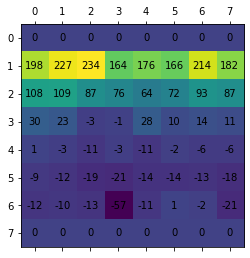

In [71]:
display_mat(ww[6:6+64].reshape(8, 8))

Таблицы фигура-поле для короля в миттельшпиле:

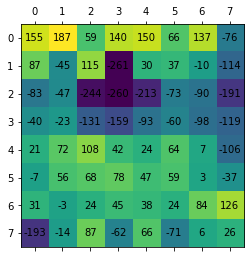

In [72]:
display_mat(ww[6+64:6+128].reshape(8, 8))

Таблицы фигура-поле для коня:

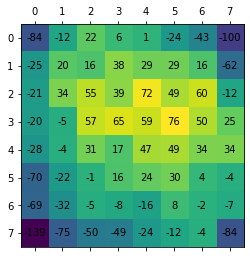

In [73]:
display_mat(ww[6+128:6+192].reshape(8, 8))

Таблицы фигура-поле для слона:

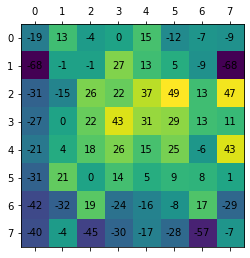

In [74]:
display_mat(ww[6+192:6+256].reshape(8, 8))

Таблицы фигура-поле для ладьи:

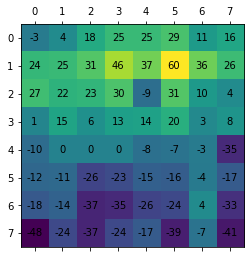

In [75]:
display_mat(ww[6+256:6+320].reshape(8, 8))

Таблицы фигура-поле для ферзя:

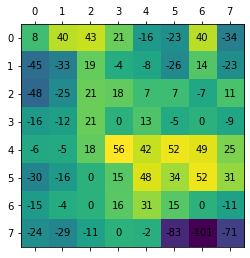

In [76]:
display_mat(ww[6+320:6+384].reshape(8, 8))

Таблицы фигура-поле для короля в эндшпиле:

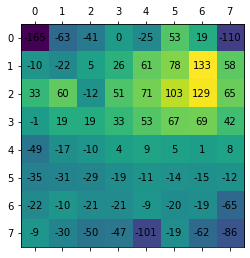

In [77]:
display_mat(ww[6+384:6+448].reshape(8, 8))

Стоимость ферзя, близкого к вражескому королю, и стоимость двух слонов:

In [78]:
ww[454], ww[455]

(70, 45)

Стоимость пешек: изолированная, двойная, проходная:

In [79]:
ww[456], ww[457], ww[458]

(-11, -2, 58)